In [1]:
! pip install pip transformers torch

In [4]:
import json
with open('/content/data/clinc150_uci/data_full.json') as f:
  data = json.load(f)

In [5]:
data.keys()

dict_keys(['oos_val', 'val', 'train', 'oos_test', 'test', 'oos_train'])

In [6]:
data['oos_train'][:10]

[['how much is an overdraft fee for bank', 'oos'],
 ['why are exponents preformed before multiplication in the order of operations',
  'oos'],
 ['what size wipers does this car take', 'oos'],
 ['where is the dipstick', 'oos'],
 ['how much is 1 share of aapl', 'oos'],
 ['how is glue made', 'oos'],
 ['any headlines from my area', 'oos'],
 ['what is the largest state in the us', 'oos'],
 ['what is the current market trend', 'oos'],
 ['what is the most popular airline', 'oos']]

In [7]:
ood_keys = [key for key in data.keys() if 'oos' in key]
data['oos'] = []
for key in ood_keys:
  data['oos'] += data.pop(key)

In [8]:
data['train'][:10]

[['what expression would i use to say i love you if i were an italian',
  'translate'],
 ["can you tell me how to say 'i do not speak much spanish', in spanish",
  'translate'],
 ["what is the equivalent of, 'life is good' in french", 'translate'],
 ["tell me how to say, 'it is a beautiful morning' in italian", 'translate'],
 ['if i were mongolian, how would i say that i am a tourist', 'translate'],
 ["how do i say 'hotel' in finnish", 'translate'],
 ["i need you to translate the sentence, 'we will be there soon' into portuguese",
  'translate'],
 ['please tell me how to ask for a taxi in french', 'translate'],
 ["can you tell me how i would say, 'more bread please' in french",
  'translate'],
 ["what is the correct way to say 'i am a visitor' in french", 'translate']]

In [9]:
data['oos'][:10]

[['set a warning for when my bank account starts running low', 'oos'],
 ['a show on broadway', 'oos'],
 ['who has the best record in the nfl', 'oos'],
 ['how do i find the area of a circle', 'oos'],
 ['how many onions do i have on hand', 'oos'],
 ['what is the name of the 13th president', 'oos'],
 ['show me recent activity in my backyard', 'oos'],
 ['how long will it take me to pay off my card if i pay an extra $50 a month over the minimum',
  'oos'],
 ['does our bank have free notary', 'oos'],
 ['what were the top stories this week', 'oos']]

In [10]:
from transformers import AutoTokenizer, DataCollatorWithPadding

checkpoint = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
data_collator = DataCollatorWithPadding(tokenizer)

In [11]:
from torch.utils.data import Dataset

class HuggingFaceDataset(Dataset):
  def __init__(self, label2id, tokenizer, texts, labels=None, subset=None):
    self._dict = tokenizer(texts, truncation=True)
    if labels is not None:
      self._dict['labels'] = [label2id[label] for label in labels]

  def __len__(self):
        return len(self._dict["input_ids"])

  def __getitem__(self, idx):
      return {k: v[idx] for k, v in self._dict.items()}

label_names = sorted({label for _, label in data['train']})
id2label = dict(enumerate(sorted(label_names)))
label2id = {v: k for k, v in id2label.items()}

datasets_hf = {}
for key, dataset in data.items():
  texts, labels = map(list,zip(*dataset))
  if labels[0] == 'oos':
    labels = None
  datasets_hf[key] = HuggingFaceDataset(label2id, tokenizer, texts, labels) 

In [12]:
for key, dataset in datasets_hf.items():
  print(key, len(dataset))

val 3000
train 15000
test 4500
oos 1200


(array([1.013e+03, 4.410e+03, 6.366e+03, 2.022e+03, 7.220e+02, 3.610e+02,
        6.800e+01, 3.200e+01, 4.000e+00, 2.000e+00]),
 array([ 3. ,  6.4,  9.8, 13.2, 16.6, 20. , 23.4, 26.8, 30.2, 33.6, 37. ]),
 <a list of 10 Patch objects>)

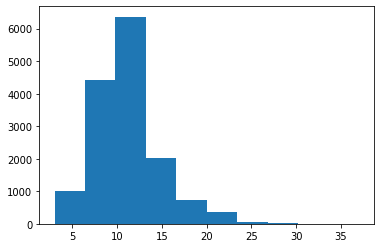

In [13]:
import matplotlib.pyplot as plt
plt.hist([len(sample['input_ids']) for sample in datasets_hf['train']])

In [14]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [15]:
from transformers import TrainingArguments

batch_size=32
args = TrainingArguments(
    "inscope_text_classification",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=5e-5,
    num_train_epochs=10,
    weight_decay=0.01,
    group_by_length=True,
    warmup_ratio=0.1,
    load_best_model_at_end=True
)


In [16]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

def compute_metrics(eval_pred):
  """Called to compute validation metrics at each evaluation step of training."""
  logits, labels = eval_pred
  labels = labels.flatten()
  predictions = np.argmax(logits, axis=-1).flatten()

  precision, recall, f1, _ = precision_recall_fscore_support(
      labels, predictions, average='macro', zero_division=0
  )
  metrics = {"f1": f1, "precision": precision, "recall": recall}
  return metrics

In [17]:
from transformers import Trainer, DataCollatorWithPadding, EarlyStoppingCallback

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=datasets_hf['train'],
    eval_dataset=datasets_hf['val'],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)
# trainer.train()

In [18]:
model = AutoModelForSequenceClassification.from_pretrained('/content/models/inscope_text_classification/checkpoint-3283')

loading configuration file /content/models/inscope_text_classification/checkpoint-3283/config.json
Model config RobertaConfig {
  "_name_or_path": "/content/models/inscope_text_classification/checkpoint-3283",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "accept_reservations",
    "1": "account_blocked",
    "2": "alarm",
    "3": "application_status",
    "4": "apr",
    "5": "are_you_a_bot",
    "6": "balance",
    "7": "bill_balance",
    "8": "bill_due",
    "9": "book_flight",
    "10": "book_hotel",
    "11": "calculator",
    "12": "calendar",
    "13": "calendar_update",
    "14": "calories",
    "15": "cancel",
    "16": "cancel_reservation",
    "17": "car_rental",
    "18": "card_declined",
    "19": "carry_on",
    "20": "change_accent",
    "21"

In [19]:
import torch

def get_model_outputs(dataset_hf, model, batch_size, device):
  model.to(device)
  model.eval()
  dataloader = torch.utils.data.DataLoader(
      dataset_hf, batch_size=batch_size, collate_fn=data_collator
  )

  latent_states = torch.zeros(len(dataset_hf), model.config.hidden_size)
  logits = torch.zeros(len(dataset_hf), model.config.num_labels)
  with torch.set_grad_enabled(False):
      for idx, batch in zip(range(0, len(dataset_hf), batch_size), dataloader):
          batch.pop("labels", default=None)
          batch = {k: v.to(device) for k, v in batch.items()}
          output = model(**batch, output_hidden_states=True)
          latent_states[idx:idx+batch_size] = output['hidden_states'][-1][:,0].detach()
          logits[idx:idx+batch_size] = output['logits'].detach()
  return logits, latent_states
       

In [20]:
import random
RANDOM_SEED = 23
SUB_SAMPLE_SIZE=1000

random.seed(RANDOM_SEED)
sub_sample_data_train = random.sample(data['train'], SUB_SAMPLE_SIZE)
texts, labels = map(list,zip(*sub_sample_data_train))
datasets_hf['train'] = HuggingFaceDataset(label2id, tokenizer, texts)

In [21]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
latent_states = {}
logits = {}
for key, dataset in datasets_hf.items():
  logits[key], latent_states[key] = get_model_outputs(dataset, model, batch_size, device)

In [22]:
for k, (latent_state) in latent_states.items():
  print(k, latent_state.size())

val torch.Size([3000, 768])
train torch.Size([1000, 768])
test torch.Size([4500, 768])
oos torch.Size([1200, 768])


Weight Fitting Epoch: 2000/10000 ; Error: 5.77e+05 ; Regulator: 1.76e+03 ; Reg Factor: 0.398
Weight Fitting Epoch: 4000/10000 ; Error: 6.89e+04 ; Regulator: 414 ; Reg Factor: 1.58
Weight Fitting Epoch: 6000/10000 ; Error: 4.8e+04 ; Regulator: 197 ; Reg Factor: 6.31
Weight Fitting Epoch: 8000/10000 ; Error: 4.17e+04 ; Regulator: 85 ; Reg Factor: 25.1
Weight Fitting Epoch: 10000/10000 ; Error: 3.97e+04 ; Regulator: 24.5 ; Reg Factor: 99.9


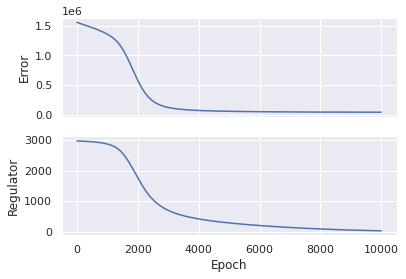

Weight Fitting Epoch: 2000/10000 ; Error: 8.67e+05 ; Regulator: 2.64e+03 ; Reg Factor: 0.398
Weight Fitting Epoch: 4000/10000 ; Error: 1.03e+05 ; Regulator: 621 ; Reg Factor: 1.58
Weight Fitting Epoch: 6000/10000 ; Error: 7.19e+04 ; Regulator: 296 ; Reg Factor: 6.31
Weight Fitting Epoch: 8000/10000 ; Error: 6.25e+04 ; Regulator: 127 ; Reg Factor: 25.1
Weight Fitting Epoch: 10000/10000 ; Error: 5.95e+04 ; Regulator: 36.7 ; Reg Factor: 99.9


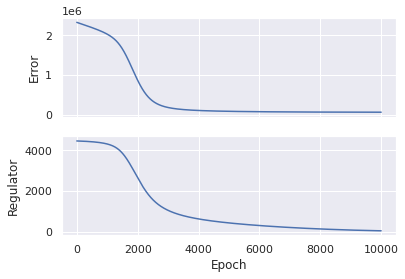

Weight Fitting Epoch: 2000/10000 ; Error: 3.55e+05 ; Regulator: 869 ; Reg Factor: 0.398
Weight Fitting Epoch: 4000/10000 ; Error: 2.58e+05 ; Regulator: 438 ; Reg Factor: 1.58
Weight Fitting Epoch: 6000/10000 ; Error: 2.48e+05 ; Regulator: 212 ; Reg Factor: 6.31
Weight Fitting Epoch: 8000/10000 ; Error: 2.44e+05 ; Regulator: 57.5 ; Reg Factor: 25.1
Weight Fitting Epoch: 10000/10000 ; Error: 2.44e+05 ; Regulator: 7.71 ; Reg Factor: 99.9


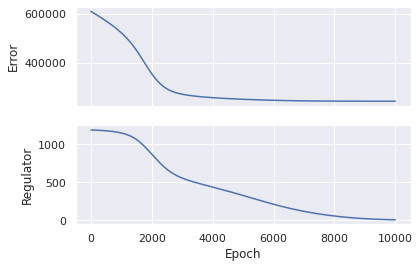

In [23]:
from explainers.simplex import Simplex
from utils.schedulers import ExponentialScheduler

fit_keys=['val', 'test', 'oos']
explainers = {}
N_KEEP = 10

model_name = 'Simplex'
model_names={model_name}

for key in fit_keys:
  simplex = Simplex(latent_states['train'].to(device).detach())
  latent_state = latent_states[key]
  reg_factor_scheduler = ExponentialScheduler(0.1, 100, 10000)
  simplex.fit(
        latent_state.to(device).detach(), 
        n_epoch=10000,
        reg_factor=0.1, 
        n_keep=N_KEEP,
        reg_factor_scheduler=reg_factor_scheduler,
      )
  simplex.plot_hist()
  explainers[f"{model_name} {key}"] = simplex
  

In [24]:
from explainers.nearest_neighbours import NearNeighLatent

model_name = "NN"
model_names.add(model_name)

for key in fit_keys:
  nn_dist = NearNeighLatent(
      corpus_latent_reps=latent_states['train'].cpu(), 
      weights_type='distance'
    )
  latent_state = latent_states[key].cpu()
  nn_dist.fit(test_latent_reps=latent_state,
              n_keep=N_KEEP)
  explainers[f"{model_name} {key}"] = nn_dist

In [25]:
from torch.nn.functional import pairwise_distance
from sklearn.metrics import r2_score

distances={}
r2_scores={}

for name, explainer in explainers.items():
  latent_rep=explainer.test_latent_reps.cpu()
  latent_approx=explainer.latent_approx().cpu()
  distances[name]=pairwise_distance(latent_rep, latent_approx)
  r2_scores[name]=r2_score(latent_rep, latent_approx)

In [26]:
r2_scores

{'NN oos': 0.37565389178854,
 'NN test': 0.9491254850903695,
 'NN val': 0.9497541783320425,
 'Simplex oos': 0.570337151756094,
 'Simplex test': 0.9723829977429203,
 'Simplex val': 0.9724334439267731}

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else n

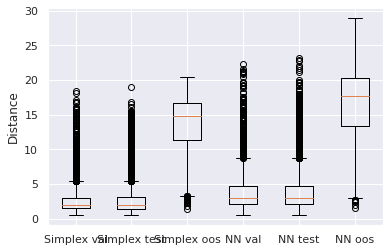

In [27]:
fig, ax = plt.subplots()
ax.boxplot(distances.values())
ax.set_xticklabels(distances.keys())
ax.set_ylabel('Distance')
plt.show()

In [28]:
from scipy.stats import ks_2samp

ks_2_samp_metrics = {}
for model_name in model_names:
  for fit_key in ['oos', 'test']:
    key=f"{model_name} {fit_key}"
    ks_2_samp_metrics[key] = ks_2samp(distances[f"{model_name} val"], distances[key])

ks_2_samp_metrics

{'NN oos': Ks_2sampResult(statistic=0.8271666666666667, pvalue=0.0),
 'NN test': Ks_2sampResult(statistic=0.017888888888888888, pvalue=1.0),
 'Simplex oos': Ks_2sampResult(statistic=0.8545, pvalue=0.0),
 'Simplex test': Ks_2sampResult(statistic=0.013111111111111112, pvalue=1.0)}

(array([0.00916917, 0.01921159, 0.01877496, 0.03056389, 0.04191619,
        0.05501503, 0.07990274, 0.13055148, 0.11526947, 0.02357787]),
 array([ 1.3526509,  3.261221 ,  5.169791 ,  7.0783615,  8.986932 ,
        10.895502 , 12.804071 , 14.712642 , 16.621212 , 18.529783 ,
        20.438353 ], dtype=float32),
 <a list of 10 Patch objects>)

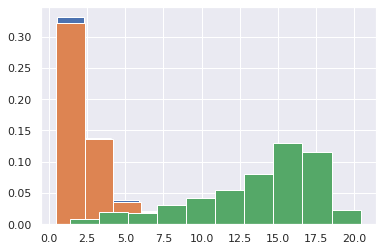

In [29]:
pdf_val = np.sort(distances['Simplex val'].numpy())
pdf_test = np.sort(distances['Simplex test'].numpy())
pdf_oos = np.sort(distances['Simplex oos'].numpy())
fig, ax = plt.subplots()
ax.hist(pdf_val, density=True)
ax.hist(pdf_test, density=True)
ax.hist(pdf_oos, density=True)

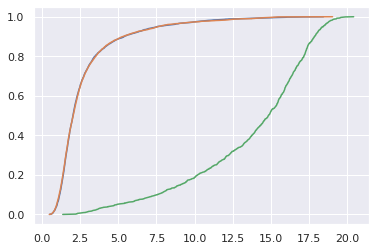

In [30]:
fig, ax = plt.subplots()
plt.plot(pdf_val, np.linspace(0, 1, num=len(pdf_val)))
plt.plot(pdf_test, np.linspace(0, 1, num=len(pdf_test)))
plt.plot(pdf_oos, np.linspace(0, 1, num=len(pdf_oos)))

In [31]:
def get_prob_pdf_has_greater_equal(value, pdf):
  # TODO: Improve naive implementation with suboptimal time complexity
  try:
    idx = next(idx for idx, value_lookup in enumerate(pdf) if value_lookup >= value)
  except StopIteration:
    idx = len(pdf)
  return 1-(idx/len(pdf))

In [32]:
prob_dist_from_val_distr = {}

for model_name in model_names:
  pdf = np.sort(distances[f"{model_name} val"].numpy())
  for data_key in ['test', 'oos']:
    prob_dist_from_val_distr[f"{model_name} {data_key}"] = np.array([get_prob_pdf_has_greater_equal(dist, pdf) for dist in distances[f"{model_name} {data_key}"]])

In [33]:
def get_max_probs_from_logits(logits):
  probs = torch.nn.Softmax(dim=-1)(logits)
  max_probs = torch.max(probs, dim=-1)[0]
  return max_probs

In [55]:
model_name = 'Logits'
model_names.add(model_name)
pdf = np.sort(1-get_max_probs_from_logits(logits['val']))
for data_key in ['test', 'oos']:
  max_probs = 1-get_max_probs_from_logits(logits[data_key])
  prob_dist_from_val_distr[f"{model_name} {data_key}"] = np.array([get_prob_pdf_has_greater_equal(max_prob, pdf) for max_prob in max_probs])

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


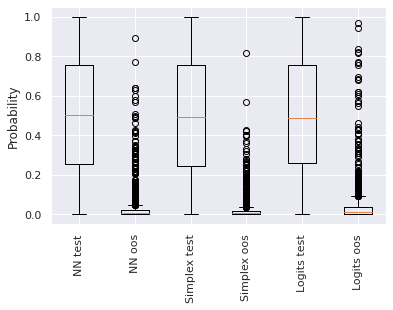

In [56]:
fig, ax = plt.subplots()
ax.boxplot(prob_dist_from_val_distr.values())
ax.set_xticklabels(prob_dist_from_val_distr.keys(), rotation=90)
ax.set_ylabel('Probability')
plt.show()

In [57]:
THRESHOLD = 0.05
OOS_VALUE = 1
INSCOPE_VALUE = 0
threshold_OOD = {key: np.where(probs<=THRESHOLD,OOS_VALUE,INSCOPE_VALUE) for key, probs in prob_dist_from_val_distr.items()}

In [58]:
from sklearn.metrics import classification_report, confusion_matrix

for name in model_names:
  oos = threshold_OOD[f'{name} oos']
  inscope = threshold_OOD[f'{name} test']
  y_pred = np.append(oos, inscope)
  y_true = np.append(np.ones(len(oos)), np.zeros(len(inscope)))
  print(name)
  print(confusion_matrix(y_true, y_pred))
  print(precision_recall_fscore_support(y_true, y_pred, average='binary'))

Logits
[[4278  222]
 [ 234  966]]
(0.8131313131313131, 0.805, 0.8090452261306532, None)
NN
[[4267  233]
 [ 163 1037]]
(0.8165354330708662, 0.8641666666666666, 0.8396761133603239, None)
Simplex
[[4271  229]
 [ 122 1078]]
(0.8247895944912013, 0.8983333333333333, 0.8599920223374551, None)


In [59]:
predictions_test = logits['test'].argmax(dim=-1)
incorrect_OOD_preds = []
incorrect_or_OOD_labels = np.zeros(len(threshold_OOD['Simplex test']))
for idx, (sample, label_prediction, OOD_prediction) in enumerate(zip(datasets_hf['test'], predictions_test, threshold_OOD['Simplex test'])):
  if sample['labels'] != label_prediction:
    incorrect_OOD_preds.append(OOD_prediction)
    incorrect_or_OOD_labels[idx] = OOS_VALUE


In [60]:
num_incorrect_labels = len(incorrect_OOD_preds)
num_correct_labels = len(threshold_OOD['Simplex test']) - num_incorrect_labels
num_OOD_predictions = sum(threshold_OOD['Simplex test'])

In [61]:
from scipy.stats import chi2_contingency

pred_OOD_and_incorrect_label = sum(incorrect_OOD_preds)
pred_OOD_and_correct_label = num_OOD_predictions - pred_OOD_and_incorrect_label
not_pred_OOD_and_incorrect_label = num_incorrect_labels - pred_OOD_and_incorrect_label
not_pred_OOD_and_correct_label = num_correct_labels - pred_OOD_and_correct_label

chi2_contingency([[pred_OOD_and_incorrect_label, pred_OOD_and_correct_label], 
                  [not_pred_OOD_and_incorrect_label, not_pred_OOD_and_correct_label]])

(1299.2277189049287,
 1.6636013499880794e-284,
 1,
 array([[   7.98955556,  221.01044444],
        [ 149.01044444, 4121.98955556]]))

In [62]:
for name in model_names:
  y_pred = threshold_OOD[f'{name} test']
  y_true = incorrect_or_OOD_labels
  print(name)
  print(confusion_matrix(y_true, y_pred))
  print(precision_recall_fscore_support(y_true, y_pred, average='binary'))

Logits
[[4218  125]
 [  60   97]]
(0.4369369369369369, 0.6178343949044586, 0.5118733509234829, None)
NN
[[4205  138]
 [  62   95]]
(0.40772532188841204, 0.6050955414012739, 0.4871794871794871, None)
Simplex
[[4220  123]
 [  51  106]]
(0.462882096069869, 0.6751592356687898, 0.5492227979274612, None)


In [63]:
stop

NameError: ignored

In [ ]:
def get_model_outputs(dataset_hf, model, batch_size, device):
  model.to(device)
  model.eval()
  dataloader = torch.utils.data.DataLoader(
      dataset_hf, batch_size=batch_size, collate_fn=data_collator
  )

  latent_states = torch.zeros(len(dataset_hf), model.config.hidden_size)
  labels = torch.zeros(len(dataset_hf))
  logits = torch.zeros(len(dataset_hf), model.config.num_labels)
  
  with torch.set_grad_enabled(False):
      for idx, batch in zip(range(0, len(dataset_hf), batch_size), dataloader):
          batch_labels = batch.pop("labels", default=None)
          if batch_labels is not None:
            labels[idx:idx+batch_size] = batch_labels
          batch = {k: v.to(device) for k, v in batch.items()}
          output = model(**batch, output_hidden_states=True)
          
          latent_states[idx:idx+batch_size] = output['hidden_states'][-1][:,0].detach()
          logits[idx:idx+batch_size] = output['logits']
  return latent_states, labels, logits

In [ ]:
latent_states_val, labels_val, logits_val = get_model_outputs(datasets_hf['val'], model, batch_size, device)
predictions_val = logits_val.argmax(dim=-1)

In [ ]:
predictions_val.size()

In [ ]:
correct = []
incorrect = []
for latent_state, label, prediction in zip(latent_states_val, labels_val, predictions_val):
  if label != prediction:
    incorrect.append(latent_state)
  else:
    correct.append(latent_state)
correct = torch.vstack(correct)
incorrect = torch.vstack(incorrect)

In [ ]:
correct.size()

In [ ]:
fit_keys=['val', 'test', 'oos']
explainers = {}
N_KEEP = 10

model_name = 'Simplex'
for name, latent_state in zip(['correct', 'incorrect'], [correct, incorrect]):
  simplex = Simplex(latent_states['train'].to(device).detach())
  reg_factor_scheduler = ExponentialScheduler(0.1, 100, 10000)
  simplex.fit(
        latent_state.to(device).detach(), 
        n_epoch=10000,
        reg_factor=0.1, 
        n_keep=N_KEEP,
        reg_factor_scheduler=reg_factor_scheduler,
      )
  simplex.plot_hist()
  explainers[f"{name} {key}"] = simplex

In [ ]:
errors={}
r2_scores={}

for name, explainer in explainers.items():
  latent_rep=explainer.test_latent_reps.cpu()
  latent_approx=explainer.latent_approx().cpu()
  errors[name]=pairwise_distance(latent_rep, latent_approx)
  r2_scores[name]=r2_score(latent_rep, latent_approx)

In [ ]:
r2_scores

In [ ]:
correct_max_logits = []
incorrect_max_logits = []
probs = torch.nn.Softmax(dim=-1)(logits_val)
max_probs = torch.max(probs, dim=-1)[0]
for max_prob, label, prediction in zip(max_probs, labels_val, predictions_val):
  if label != prediction:
    incorrect_max_logits.append(max_prob)
  else:
    correct_max_logits.append(max_prob)

In [ ]:
latent_states_oos, labels_oos, logits_oos = get_model_outputs(datasets_hf['oos'], model, batch_size, device)
probs_oos = torch.nn.Softmax(dim=-1)(logits_val)
max_probs_oos = torch.max(probs_oos, dim=-1)[0]

In [ ]:
fig, ax = plt.subplots()
ax.boxplot([correct_max_logits, incorrect_max_logits, max_probs_oos.numpy()])
plt.show()

In [ ]:
ks_2samp(incorrect_max_logits, correct_max_logits)

In [ ]:
fig, ax = plt.subplots()
ax.boxplot([error.numpy() for error in errors.values()])
ax.set_xticklabels(errors.keys())
ax.set_ylabel('Distance')
plt.show()

In [ ]:
ks_2samp(errors['correct Simplex test'], errors['incorrect Simplex test'])